In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 82.2 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import timm  # Timm provides pretrained models, including Vision Transformers
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split  # Add random_split here

In [4]:
# Data augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.RandomVerticalFlip(),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# Load the full dataset
full_dataset = ImageFolder(root="/content/drive/MyDrive/Apple", transform=transform)

# Define the dataset lengths based on 65%, 25%, and 10% splits
train_size = int(0.65 * len(full_dataset))
val_size = int(0.25 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size  # Remaining for test set

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create DataLoaders for each split
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Print dataset sizes to confirm the split
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 2061
Validation dataset size: 792
Test dataset size: 318


In [6]:
# Load pretrained Vision Transformer model
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=10)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [7]:
# Freeze all layers except the last few for fine-tuning
for param in model.parameters():
    param.requires_grad = False
for param in model.blocks[-1].parameters():  # Fine-tuning only the last transformer block
    param.requires_grad = True
for param in model.head.parameters():  # Fine-tuning the classifier head
    param.requires_grad = True

In [8]:
# Move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [9]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)

In [10]:
# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Early stopping mechanism
early_stopping_patience = 5
early_stopping_counter = 0
best_val_loss = float('inf')

train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [11]:
for epoch in range(50):  # Increase the number of epochs if necessary
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / total
    train_acc = correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= total
    val_acc = correct / total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f"Epoch [{epoch+1}/50], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

    # Adjust the learning rate based on validation loss
    scheduler.step(val_loss)

KeyboardInterrupt: 

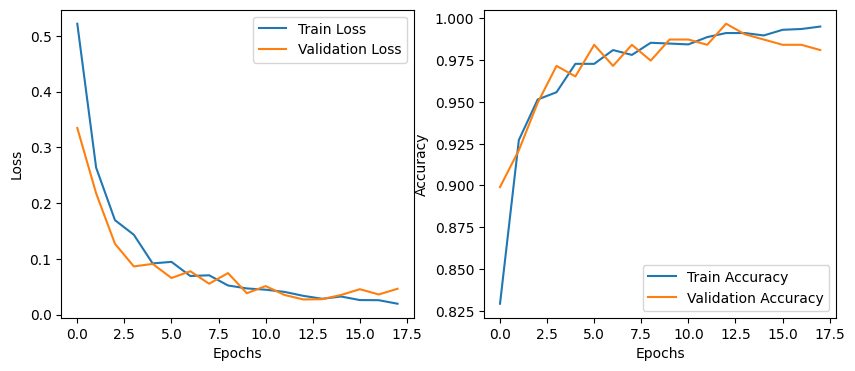

<ipython-input-14-ecde8106547c>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

In [ ]:
# Plotting results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label="Train Accuracy")
plt.plot(val_acc_history, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

# Load the best model for testing
model.load_state_dict(torch.load('best_model.pth'))

In [ ]:
import torch

# Define a path to save the model
model_save_path = "/content/drive/MyDrive/apple_model_1.pth"

# Assuming your model is defined as `vit`
torch.save(model.state_dict(), model_save_path)  # Saves the state_dict (model parameters)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/apple_model_1.pth


Saving 0cd24b0c-0a9d-483f-8734-5c08988e029f___FREC_C.Rust 3762_final_masked.jpg to 0cd24b0c-0a9d-483f-8734-5c08988e029f___FREC_C.Rust 3762_final_masked.jpg
Uploaded file: 0cd24b0c-0a9d-483f-8734-5c08988e029f___FREC_C.Rust 3762_final_masked.jpg
File 0cd24b0c-0a9d-483f-8734-5c08988e029f___FREC_C.Rust 3762_final_masked.jpg found.


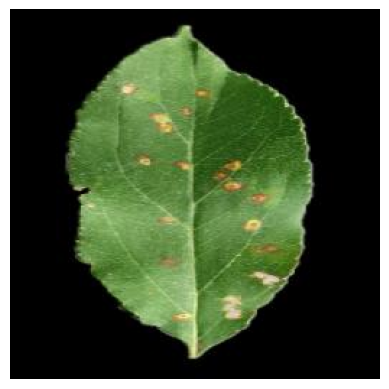

NameError: name 'model' is not defined

In [ ]:
# Import necessary libraries
import torch
import torchvision.transforms as transforms
from google.colab import files
from PIL import Image
import os
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt  # Importing matplotlib for image display

# Function to display an image
def display_image(image_path):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()  # Show the image

# Function to make predictions on images and plot them with prediction confidence
def pred_and_plot_image(model, image_path, class_names, device):
    # Load image
    img = Image.open(image_path).convert("RGB")
    img = img.resize((224, 224))  # Assuming your model uses 224x224 image size

    # Preprocess image (adjust based on your model's preprocessing)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    img = transform(img).unsqueeze(0).to(device)

    # Set model to evaluation mode and make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(img)  # Get raw model outputs (logits)
        probabilities = torch.softmax(outputs, dim=1)  # Apply softmax to get probabilities
        confidence, predicted_class = torch.max(probabilities, 1)  # Get the class with highest probability

    # Get class name and confidence
    predicted_class_name = class_names[predicted_class.item()]
    predicted_confidence = confidence.item()

    # Return result
    return predicted_class_name, predicted_confidence

# Assuming you used ImageFolder to load your dataset for training
# This will extract the class names automatically from your dataset folder structure
dataset = ImageFolder(root="/content/drive/MyDrive/Apple", transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
]))
class_names = dataset.classes  # Extract class names from the dataset

# Upload the image from local machine
uploaded = files.upload()

# Get the uploaded file name
image_filename = list(uploaded.keys())[0]
print(f"Uploaded file: {image_filename}")

# Ensure the uploaded image file exists
if os.path.isfile(image_filename):
    print(f"File {image_filename} found.")
else:
    raise FileNotFoundError(f"{image_filename} not found. Please upload the file.")

# Display the uploaded image
display_image(image_filename)  # Call the display function to show the image

# Assuming 'vit' is your model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)  # Move model to GPU if available

# Call the prediction function
predicted_class_name, predicted_confidence = pred_and_plot_image(model, image_path=image_filename, class_names=class_names, device=device)

# Define your disease cure database
disease_cure_database = {
    "apple_scab": {
        "description": "Apple scab is caused by the fungus Venturia inaequalis, which results in dark, scabby lesions on the leaves, fruit, and sometimes young shoots.",
        "cures": [
            "Use fungicides such as captan, mancozeb, or sulfur-based sprays during the growing season.",
            "Prune and dispose of infected leaves and fruits to reduce the spread of the fungus.",
            "Ensure proper air circulation by thinning the trees and avoid overhead watering."
        ]
    },
    "apple_Black_rot": {
        "description": "Apple Black Rot is caused by the fungus Botryosphaeria obtusa. It causes cankers on branches, black spots on fruit, and leaf lesions.",
        "cures": [
            "Prune infected branches during the dormant season.",
            "Remove and destroy infected fruit and leaves.",
            "Use fungicides like captan or myclobutanil, especially after fruit set."
        ]
    },
    "apple_Cedar_apple_rust": {
        "description": "Cedar apple rust is caused by the fungus Gymnosporangium juniperi-virginianae. It leads to orange spots on the leaves and fruit, reducing the yield.",
        "cures": [
            "Apply fungicides such as myclobutanil or mancozeb in early spring.",
            "Remove any nearby cedar or juniper trees to reduce the source of the fungus.",
            "Prune affected parts of the tree to limit spread."
        ]
    },
    "apple_healthy": {
        "description": "No disease present; ensure ongoing healthy practices to maintain tree health.",
        "cures": [
            "Regular watering, ensuring proper drainage.",
            "Apply balanced fertilizers to ensure the tree gets all essential nutrients.",
            "Regularly inspect for pests or early signs of disease."
        ]
    }
}

# Display the predicted class and confidence
print(f"Predicted class: {predicted_class_name} \nconfidence: {predicted_confidence * 100:.2f}\n\n")

# Display the disease description and cure if found in the database
if predicted_class_name in disease_cure_database:
    disease_info = disease_cure_database[predicted_class_name]

    print(f"Description:\n{disease_info['description']}\n")
    print("Cures:")
    for cure in disease_info['cures']:
        print(f"- {cure}")

else:
    print(f"No information available for the predicted class: {predicted_class_name}")


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a list or dictionary of class names
class_names = ['apple_scab', 'apple_Black_rot','apple_Cedar_apple_rust','apple_healthy']  # Adjust based on your classes

# Function to display an image in grid
def imshow(img, title):
    img = img / 2 + 0.5  # Unnormalize the image
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

# Set model to evaluation mode
model.eval()

# Take a small batch of images from the test dataset
num_images = 10  # You can adjust this to 10-20
images_so_far = 0
fig = plt.figure(figsize=(15, 15))  # Create a figure to hold the grid

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Predict the output
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Display only the first num_images in grid
        for i in range(inputs.size()[0]):
            if images_so_far == num_images:
                break

            images_so_far += 1
            ax = plt.subplot(4, 5, images_so_far)  # Adjust grid size accordingly
            ax.axis('off')
            img_title = f'Pred: {class_names[predicted[i]]}, True: {class_names[labels[i]]}'
            imshow(inputs.cpu().data[i], title=img_title)

        if images_so_far == num_images:
            break

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy on test data: {accuracy:.2f}%')

plt.tight_layout()
plt.show()
